In [97]:

import numpy as np
import text_normalize as tn
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import nltk
from collections import Counter
from IPython.core.debugger import set_trace

# Visualization
import matplotlib.pyplot as plt

# Model building
from sklearn.datasets import fetch_20newsgroups
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date. We'll build a model to classify these each newsgroups into one of the 20 topics using their text contents.

## Data Retrieval and Preprocessing

We will strip HTML markups, expand contractions such as can't into cannot, remove accented character, lowercase all words, lemmatize, remove special characters and stopwords from our text corpus.

In [28]:
data = fetch_20newsgroups(subset='all', shuffle=True,
                          remove=('headers', 'footers', 'quotes'))
data_labels_map = dict(enumerate(data.target_names))

In [29]:
corpus, target_labels, target_names = (data.data, data.target,
                                       [data_labels_map[label] for label in data.target])
data_df = pd.DataFrame({'Article': corpus, 'Target Label': target_labels, 'Target Name': target_names})
print(data_df.shape)
data_df.head(10)

(18846, 3)


,Article,Target Label,Target Name
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware
5,\n\nBack in high school I worked as a lab assi...,12,sci.electronics
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,4,comp.sys.mac.hardware
7,"\n[stuff deleted]\n\nOk, here's the solution t...",10,rec.sport.hockey
8,"\n\n\nYeah, it's the second one. And I believ...",10,rec.sport.hockey
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc


In [35]:
count = data_df['Target Name'].value_counts().sort_index(ascending=True)
labels, freq = count.values, count.index
labels, freq

(array([799, 973, 985, 982, 963, 988, 975, 990, 996, 994, 999, 991, 984,
        990, 987, 997, 910, 940, 775, 628], dtype=int64),
 Index(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
        'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x',
        'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball',
        'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med',
        'sci.space', 'soc.religion.christian', 'talk.politics.guns',
        'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc'],
       dtype='object'))

[799 973 985 982 963 988 975 990 996 994 999 991 984 990 987 997 910 940
 775 628]
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


Text(0.5, 0, 'Frequency')

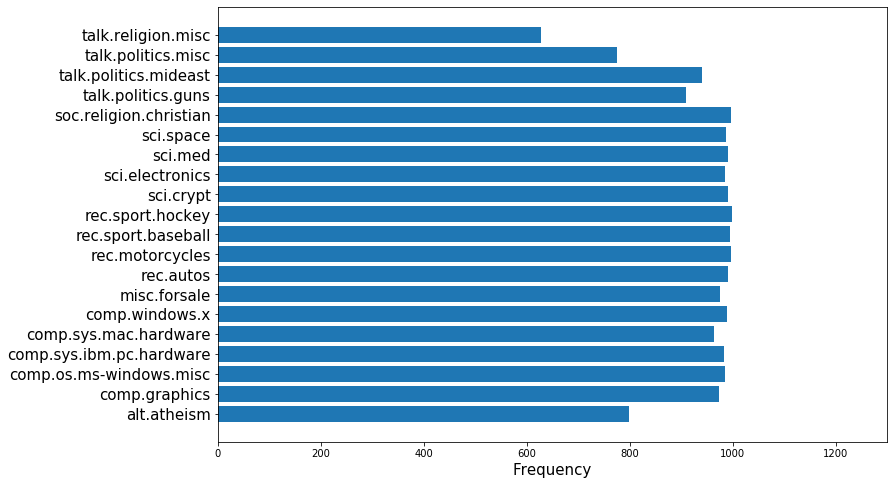

In [36]:
count = data_df['Target Name'].value_counts().sort_index(ascending=True)
freq, labels = count.values, list(count.index)
print(freq, labels, sep='\n')
x = range(len(freq))
plt.figure(figsize=(12,8))
plt.barh(x, freq)
plt.yticks(x, labels, fontsize=15)
plt.xlim(0,1000+300)
plt.xlabel('Frequency', fontsize=15)

The data seems relatively balanced. Religion topic is underrepresented, however. 

In [5]:
# Empty Document
total_nulls = data_df[data_df.Article.str.strip() == ''].shape[0]
print("Empty documents:", total_nulls)

Empty documents: 515


In [6]:
# removing nan values
data_df = data_df[~(data_df.Article.str.strip() == '')]
data_df.shape

(18331, 3)

In [7]:
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

### Single Core Preprocessing

The preprocessing step takes about 20 minutes using one core.

In [9]:
norm_corpus = tn.normalize_corpus(corpus=data_df['Article'])
data_df['Clean Article1'] = norm_corpus

We save the new clean data into column Clean Article1. Below is what the data look like after processing.

In [10]:
data_df = data_df[['Article', 'Clean Article1', 'Target Label', 'Target Name']]
data_df.head(10)

,Article,Clean Article1,Target Label,Target Name
0,\n\nI am sure some bashers of Pens fans are pr...,sure basher pen fan pretty confused lack kind ...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,brother market high performance video card sup...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,&#9; finally say dream mediterranean new &#9; ...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,think scsi card dma transfer disk scsi card dm...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,old jasmine drive use new system understanding...,4,comp.sys.mac.hardware
5,\n\nBack in high school I worked as a lab assi...,back high school work lab assistant bunch expe...,12,sci.electronics
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,ae dalla try tech support may line one get start,4,comp.sys.mac.hardware
7,"\n[stuff deleted]\n\nOk, here's the solution t...",[ stuff delete ] ok solution problem move cana...,10,rec.sport.hockey
8,"\n\n\nYeah, it's the second one. And I believ...",yeah second one believe price try get good loo...,10,rec.sport.hockey
9,\nIf a Christian means someone who believes in...,christian mean someone believe divinity jesus ...,19,talk.religion.misc


### Parallel Preprocessing

There's a significant decrease in time processing text with multi-core.

In [ ]:
norm_corpus = tn.parallel_normalize_corpus(n_processes=5,corpus=data_df['Article'].values)
data_df['Clean Article'] = norm_corpus

In [33]:
# Save clean data to a csv file for later use
data_df = data_df[['Article', 'Clean Article', 'Target Label', 'Target Name']]
display(data_df.head(10))
data_df.to_csv('Clean_data.csv', index=None, header=True)

,Article,Clean Article,Target Label,Target Name
0,\n\nI am sure some bashers of Pens fans are pr...,sure basher pen fan pretty confused lack kind ...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,brother market high performance video card sup...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,&#9; finally say dream mediterranean new &#9; ...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,think scsi card dma transfer disk scsi card dm...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,old jasmine drive use new system understanding...,4,comp.sys.mac.hardware
5,\n\nBack in high school I worked as a lab assi...,back high school work lab assistant bunch expe...,12,sci.electronics
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,ae dalla try tech support may line one get start,4,comp.sys.mac.hardware
7,"\n[stuff deleted]\n\nOk, here's the solution t...",[ stuff delete ] ok solution problem move cana...,10,rec.sport.hockey
8,"\n\n\nYeah, it's the second one. And I believ...",yeah second one believe price try get good loo...,10,rec.sport.hockey
9,\nIf a Christian means someone who believes in...,christian mean someone believe divinity jesus ...,19,talk.religion.misc


In [37]:
# Read data back in
data_df = pd.read_csv('data/Clean_data.csv')
data_df = data_df.replace(r'^(\s?)+$', np.nan, regex=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18331 entries, 0 to 18330
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Article        18331 non-null  object
 1   Clean Article  18305 non-null  object
 2   Target Label   18331 non-null  int64 
 3   Target Name    18331 non-null  object
dtypes: int64(1), object(3)
memory usage: 573.0+ KB


In [38]:
# Dropping nan values
data_df = data_df.dropna().reset_index(drop=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18305 entries, 0 to 18304
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Article        18305 non-null  object
 1   Clean Article  18305 non-null  object
 2   Target Label   18305 non-null  int64 
 3   Target Name    18305 non-null  object
dtypes: int64(1), object(3)
memory usage: 572.2+ KB


Text(0.5, 0, 'Frequency')

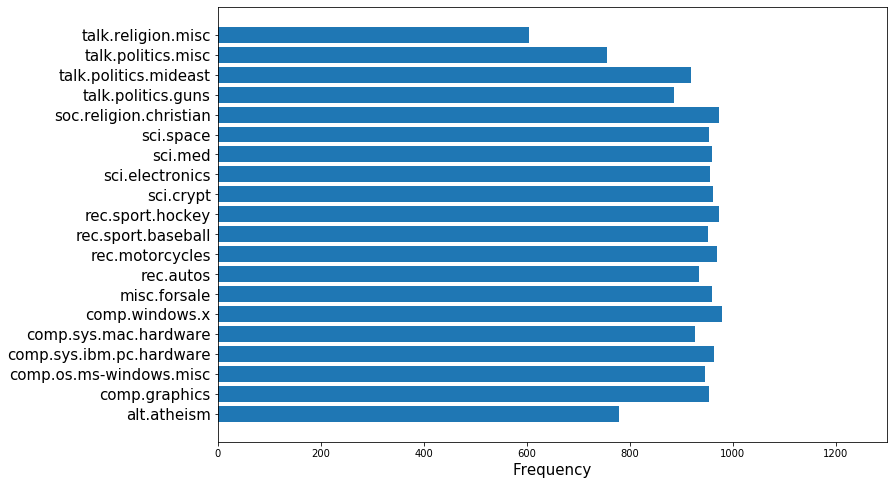

In [39]:
count = data_df['Target Name'].value_counts().sort_index(ascending=True)
freq, labels = count.values, list(count.index)
x = range(len(freq))
plt.figure(figsize=(12,8))
plt.barh(x, freq)
plt.yticks(x, labels, fontsize=15)
plt.xlim(0,1000+300)
plt.xlabel('Frequency', fontsize=15)

The distribution does not change much after preprocessing and dropping nan values

In [40]:
# Stratified tplitting Traing and Test sets 
train_corpus, test_corpus, train_label_nums, test_label_nums, train_label_names, test_label_names = train_test_split(data_df['Clean Article'],
                                         data_df['Target Label'],
                                         data_df['Target Name'],
                                         test_size=0.33, random_state=42,
                                        stratify=data_df['Target Name'])
train_corpus.shape, test_corpus.shape

((12264,), (6041,))

Text(0.5, 1.0, 'Train set distribution')

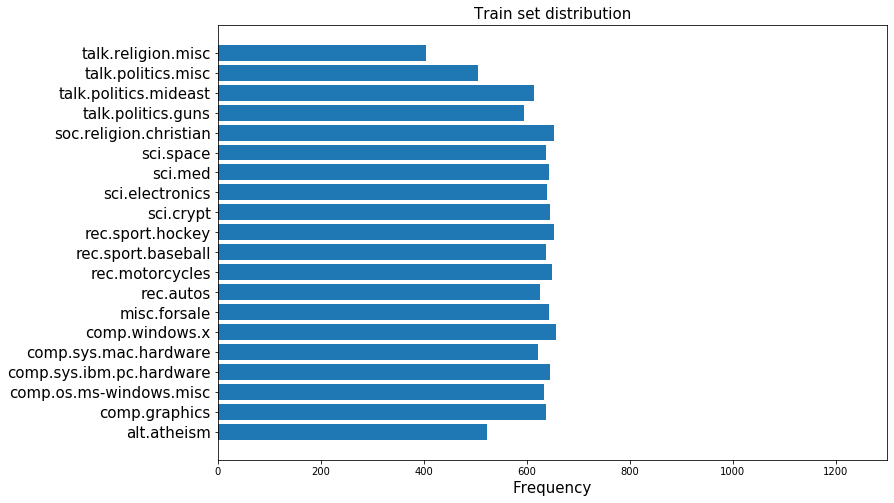

In [43]:
count = np.unique(train_label_names, return_counts=True)
labels, freq = count[0], count[1]
x = range(len(freq))
plt.figure(figsize=(12,8))
plt.barh(x, freq)
plt.yticks(x, labels, fontsize=15)
plt.xlim(0,1000+300)
plt.xlabel('Frequency', fontsize=15)
plt.title('Train set distribution', fontsize=15)

Text(0.5, 1.0, 'Test set distribution')

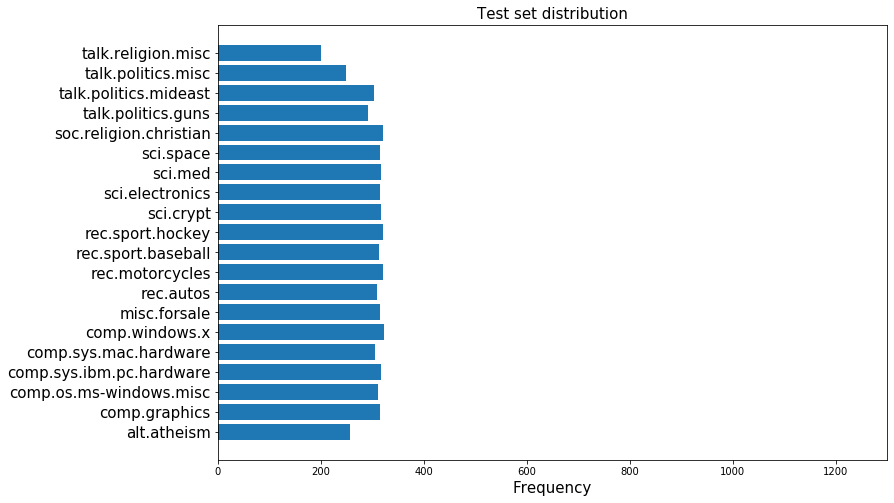

In [44]:
count = np.unique(test_label_names, return_counts=True)
labels, freq = count[0], count[1]
x = range(len(freq))
plt.figure(figsize=(12,8))
plt.barh(x, freq)
plt.yticks(x, labels, fontsize=15)
plt.xlim(0,1000+300)
plt.xlabel('Frequency', fontsize=15)
plt.title('Test set distribution', fontsize=15)

Both train and test sets have similar distribution after split

## Feature Engineering

Since machine learning models can only process numbers, we need to transform our texts into numbers before feeding them to the models

### Bag of Words

In [45]:
# build BOW features on train articles
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0)
cv_train_features = cv.fit_transform(train_corpus)
# transform test articles into features
cv_test_features = cv.transform(test_corpus)
print('BOW model:> Train features shape:', cv_train_features.shape,
      ' Test features shape:', cv_test_features.shape)

BOW model:> Train features shape: (12264, 77426)  Test features shape: (6041, 77426)


There are 77426 unique words in the corpus

#### Naive Bayes Classifier

In [46]:
mnb = MultinomialNB(alpha=1)
mnb.fit(cv_train_features, train_label_names)
mnb_bow_cv_scores = cross_val_score(mnb, cv_train_features, train_label_names, cv=5)
mnb_bow_cv_mean_score = np.mean(mnb_bow_cv_scores)
print('CV Accuracy (5-fold):', mnb_bow_cv_scores)
print('Mean CV Accuracy:', mnb_bow_cv_mean_score)
mnb_bow_test_score = mnb.score(cv_test_features, test_label_names)
print('Test Accuracy:', mnb_bow_test_score)

CV Accuracy (5-fold): [0.66382114 0.67277167 0.66788916 0.66421569 0.6801636 ]
Mean CV Accuracy: 0.6697722513987532
Test Accuracy: 0.6894553881807648


#### Logistic Regression

In [47]:
lr = LogisticRegression(penalty='l2', max_iter=100, C=1, random_state=42)
lr.fit(cv_train_features, train_label_names)
lr_bow_cv_scores = cross_val_score(lr, cv_train_features, train_label_names, cv=5)
lr_bow_cv_mean_score = np.mean(lr_bow_cv_scores)
print('CV Accuracy (5-fold):', lr_bow_cv_scores)
print('Mean CV Accuracy:', lr_bow_cv_mean_score)
lr_bow_test_score = lr.score(cv_test_features, test_label_names)
print('Test Accuracy:', lr_bow_test_score)

CV Accuracy (5-fold): [0.68577236 0.70533171 0.67603912 0.69648693 0.69529652]
Mean CV Accuracy: 0.6917853268963282
Test Accuracy: 0.7182585664625062


#### Support Vector Machines

In [48]:
svm = LinearSVC(penalty='l2', C=1, random_state=42)
svm.fit(cv_train_features, train_label_names)
svm_bow_cv_scores = cross_val_score(svm, cv_train_features, train_label_names, cv=5)
svm_bow_cv_mean_score = np.mean(svm_bow_cv_scores)
print('CV Accuracy (5-fold):', svm_bow_cv_scores)
print('Mean CV Accuracy:', svm_bow_cv_mean_score)
svm_bow_test_score = svm.score(cv_test_features, test_label_names)
print('Test Accuracy:', svm_bow_test_score)

CV Accuracy (5-fold): [0.62682927 0.64509565 0.63080685 0.64460784 0.63803681]
Mean CV Accuracy: 0.6370752824614607
Test Accuracy: 0.661479887435855


#### SVM with Stochastic Gradient Descent

In [49]:
svm_sgd = SGDClassifier(loss='hinge', penalty="l2", max_iter=5, random_state=42)
svm_sgd.fit(cv_train_features, train_label_names)
svmsgd_bow_cv_scores = cross_val_score(svm_sgd, cv_train_features, train_label_names, cv=5)
svmsgd_bow_cv_mean_score = np.mean(svmsgd_bow_cv_scores)
print('CV Accuracy (5-fold):', svmsgd_bow_cv_scores)
print('Mean CV Accuracy:', svmsgd_bow_cv_mean_score)
svmsgd_bow_test_score = svm_sgd.score(cv_test_features, test_label_names)
print('Test Accuracy:', svmsgd_bow_test_score)

CV Accuracy (5-fold): [0.61788618 0.64428164 0.62713936 0.62826797 0.63762781]
Mean CV Accuracy: 0.6310405946327522
Test Accuracy: 0.6457540142360536


#### Random Forest

In [51]:
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(cv_train_features, train_label_names)
rfc_bow_cv_scores = cross_val_score(rfc, cv_train_features, train_label_names, cv=5)
rfc_bow_cv_mean_score = np.mean(rfc_bow_cv_scores)
print('CV Accuracy (5-fold):', rfc_bow_cv_scores)
print('Mean CV Accuracy:', rfc_bow_cv_mean_score)
rfc_bow_test_score = rfc.score(cv_test_features, test_label_names)
print('Test Accuracy:', rfc_bow_test_score)

CV Accuracy (5-fold): [0.53170732 0.50712251 0.53056235 0.52205882 0.52719836]
Mean CV Accuracy: 0.5237298717843066
Test Accuracy: 0.5363350438669094


#### Gradient Boosting Machines

In [50]:
gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)
gbc.fit(cv_train_features, train_label_names)
gbc_bow_cv_scores = cross_val_score(gbc, cv_train_features, train_label_names, cv=5)
gbc_bow_cv_mean_score = np.mean(gbc_bow_cv_scores)
print('CV Accuracy (5-fold):', gbc_bow_cv_scores)
print('Mean CV Accuracy:', gbc_bow_cv_mean_score)
gbc_bow_test_score = gbc.score(cv_test_features, test_label_names)
print('Test Accuracy:', gbc_bow_test_score)

CV Accuracy (5-fold): [0.54268293 0.54171754 0.54237979 0.54697712 0.55214724]
Mean CV Accuracy: 0.545180924018936
Test Accuracy: 0.5565303757656017


### Tf-Idf 

In [52]:
# build BOW features on train articles
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0)
tv_train_features = tv.fit_transform(train_corpus)
# transform test articles into features
tv_test_features = tv.transform(test_corpus)
print('TFIDF model:> Train features shape:', tv_train_features.shape,
      ' Test features shape:', tv_test_features.shape)

TFIDF model:> Train features shape: (12264, 77426)  Test features shape: (6041, 77426)


Again, there are 77426 unique tf-idf features in the corpus

#### Naive Bayes

In [53]:
mnb = MultinomialNB(alpha=1)
mnb.fit(tv_train_features, train_label_names)
mnb_tfidf_cv_scores = cross_val_score(mnb, tv_train_features, train_label_names, cv=5)
mnb_tfidf_cv_mean_score = np.mean(mnb_tfidf_cv_scores)
print('CV Accuracy (5-fold):', mnb_tfidf_cv_scores)
print('Mean CV Accuracy:', mnb_tfidf_cv_mean_score)
mnb_tfidf_test_score = mnb.score(tv_test_features, test_label_names)
print('Test Accuracy:', mnb_tfidf_test_score)

CV Accuracy (5-fold): [0.70487805 0.71550672 0.71312143 0.71772876 0.72965235]
Mean CV Accuracy: 0.7161774617176414
Test Accuracy: 0.7293494454560503


#### Logistic Regression

In [54]:
lr = LogisticRegression(penalty='l2', max_iter=100, C=1, random_state=42)
lr.fit(tv_train_features, train_label_names)
lr_tfidf_cv_scores = cross_val_score(lr, tv_train_features, 
                                     train_label_names, cv=5,
                                    n_jobs=5)
lr_tfidf_cv_mean_score = np.mean(lr_tfidf_cv_scores)
print('CV Accuracy (5-fold):', lr_tfidf_cv_scores)
print('Mean CV Accuracy:', lr_tfidf_cv_mean_score)
lr_tfidf_test_score = lr.score(tv_test_features, test_label_names)
print('Test Accuracy:', lr_tfidf_test_score)

CV Accuracy (5-fold): [0.7296748  0.74765975 0.74327628 0.73978758 0.7402863 ]
Mean CV Accuracy: 0.74013694165883
Test Accuracy: 0.7569938751862274


#### Support Vector Machines

In [55]:
svm = LinearSVC(penalty='l2', C=1, random_state=42)
svm.fit(tv_train_features, train_label_names)
svm_tfidf_cv_scores = cross_val_score(svm, tv_train_features, train_label_names, cv=5, n_jobs = 5)
svm_tfidf_cv_mean_score = np.mean(svm_tfidf_cv_scores)
print('CV Accuracy (5-fold):', svm_tfidf_cv_scores)
print('Mean CV Accuracy:', svm_tfidf_cv_mean_score)
svm_tfidf_test_score = svm.score(tv_test_features, test_label_names)
print('Test Accuracy:', svm_tfidf_test_score)

CV Accuracy (5-fold): [0.74512195 0.76719577 0.75020375 0.76429739 0.74314928]
Mean CV Accuracy: 0.7539936274542056
Test Accuracy: 0.7704022512829002


#### SVM with Stochastic Gradient Descent

In [56]:
svm_sgd = SGDClassifier(loss='hinge', penalty="l2", max_iter=5, random_state=42)
svm_sgd.fit(tv_train_features, train_label_names)
svmsgd_tfidf_cv_scores = cross_val_score(svm_sgd, tv_train_features, train_label_names, cv=5, n_jobs=5)
svmsgd_tfidf_cv_mean_score = np.mean(svmsgd_tfidf_cv_scores)
print('CV Accuracy (5-fold):', svmsgd_tfidf_cv_scores)
print('Mean CV Accuracy:', svmsgd_tfidf_cv_mean_score)
svmsgd_tfidf_test_score = svm_sgd.score(tv_test_features, test_label_names)
print('Test Accuracy:', svmsgd_tfidf_test_score)

CV Accuracy (5-fold): [0.7495935  0.76434676 0.75509372 0.75816993 0.74928425]
Mean CV Accuracy: 0.7552976346064711
Test Accuracy: 0.7733818904154941


#### Random Forest

In [57]:
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(tv_train_features, train_label_names)
rfc_tfidf_cv_scores = cross_val_score(rfc, tv_train_features, train_label_names, cv=5, n_jobs=5)
rfc_tfidf_cv_mean_score = np.mean(rfc_tfidf_cv_scores)
print('CV Accuracy (5-fold):', rfc_tfidf_cv_scores)
print('Mean CV Accuracy:', rfc_tfidf_cv_mean_score)
rfc_tfidf_test_score = rfc.score(tv_test_features, test_label_names)
print('Test Accuracy:', rfc_tfidf_test_score)

CV Accuracy (5-fold): [0.53455285 0.52218152 0.52200489 0.50735294 0.54274029]
Mean CV Accuracy: 0.5257664970321134
Test Accuracy: 0.5489157424267506


#### Gradient Boosting

In [58]:
gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)
gbc.fit(tv_train_features, train_label_names)
gbc_tfidf_cv_scores = cross_val_score(gbc, tv_train_features, train_label_names, cv=5, n_jobs=5)
gbc_tfidf_cv_mean_score = np.mean(gbc_tfidf_cv_scores)
print('CV Accuracy (5-fold):', gbc_tfidf_cv_scores)
print('Mean CV Accuracy:', gbc_tfidf_cv_mean_score)
gbc_tfidf_test_score = gbc.score(tv_test_features, test_label_names)
print('Test Accuracy:', gbc_tfidf_test_score)

CV Accuracy (5-fold): [0.5495935  0.55311355 0.53585982 0.55637255 0.55132924]
Mean CV Accuracy: 0.54925373242456
Test Accuracy: 0.5510677040225128


In general, tf-idf feature engineering method performs better that the bow one. In addition, GradientBoosting and RandomForest do not perform as well as the other linear models. We'll fine tune the models, excluding GradientBoosting and RandomForest, with this method

### Fine Tuning

#### Naive Bayes

In [63]:
mnb_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('mnb', MultinomialNB())
                       ])
param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'mnb__alpha': [1e-5, 1e-4, 1e-2, 1e-1, 1]
}

gs_mnb = GridSearchCV(mnb_pipeline, param_grid, cv=5, verbose=2, n_jobs=6)
gs_mnb = gs_mnb.fit(train_corpus, train_label_names)


cv_results = gs_mnb.cv_results_
results_df = pd.DataFrame({'rank': cv_results['rank_test_score'],
                           'params': cv_results['params'],
                           'cv score (mean)': cv_results['mean_test_score'],
                           'cv score (std)': cv_results['std_test_score']}
              )
results_df = results_df.sort_values(by=['rank'], ascending=True)
pd.set_option('display.max_colwidth', 100)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   48.2s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  1.2min finished


In [64]:
# Test cv score on the test set
best_mnb_test_score = gs_mnb.score(test_corpus, test_label_names)
print('Test Accuracy :', best_mnb_test_score)

Test Accuracy : 0.7846383049164045


#### Logistic Regression

In [66]:
# Tuning our Logistic Regression model
lr_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('lr', LogisticRegression(penalty='l2', max_iter=100, random_state=42))
                       ])
param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'lr__C': [1, 5, 10]
}
gs_lr = GridSearchCV(lr_pipeline, param_grid, cv=5, verbose=2, n_jobs=6)
gs_lr = gs_lr.fit(train_corpus, train_label_names)

# evaluate best tuned model on the test dataset
best_lr_test_score = gs_lr.score(test_corpus, test_label_names)
print('Test Accuracy :', best_lr_test_score)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:  3.5min finished


Test Accuracy : 0.77536831650389


#### SVM

In [67]:
svm_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('svm', LinearSVC(random_state=42))
                       ])
param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'svm__C': [0.01, 0.1, 1, 5]
}
gs_svm = GridSearchCV(svm_pipeline, param_grid, cv=5, verbose=2, n_jobs=6)
gs_svm = gs_svm.fit(train_corpus, train_label_names)
# evaluating best tuned model on the test dataset
best_svm_test_score = gs_svm.score(test_corpus, test_label_names)
print('Test Accuracy :', best_svm_test_score)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:  2.1min finished


Test Accuracy : 0.7851349114385036


Fine Tuned SVM has the best performance in terms of accuracy. We'll poke into this model and see its overall performance.

### Model Evaluation

In [98]:
from utils import utils
svm_predictions = gs_svm.predict(test_corpus)
unique_classes = list(set(test_label_names))
acc, precision, recall, f1 = utils.get_metrics(true_labels=test_label_names, 
                                               predicted_labels=svm_predictions)

Accuracy: 0.7851
Precision: 0.7825
Recall: 0.7851
F1 Score: 0.7818


In [168]:
report = utils.display_classification_report(true_labels=test_label_names,
                                  predicted_labels=svm_predictions,
                                  classes=unique_classes,dict=True)


In [166]:
labels = list(report.keys())
reports = pd.DataFrame(list(report.values())[:-3], index=labels[:-3])
reports.sort_values(by=['f1-score'])

,precision,recall,f1-score,support
talk.religion.misc,0.568627,0.290000,0.384106,200
alt.atheism,0.669261,0.669261,0.669261,257
talk.politics.misc,0.708155,0.662651,0.684647,249
comp.sys.ibm.pc.hardware,0.691083,0.682390,0.686709,318
sci.electronics,0.728395,0.746835,0.737500,316
comp.os.ms-windows.misc,0.738854,0.743590,0.741214,312
comp.graphics,0.728916,0.768254,0.748068,315
talk.politics.guns,0.720859,0.804795,0.760518,292
soc.religion.christian,0.717678,0.847352,0.777143,321
comp.sys.mac.hardware,0.775974,0.781046,0.778502,306


The report is sorted in an ascending order. It shows that our model performs worst on religion. As we showed above, the distribution of religion is underrepresented in our dataset. Thus, this could be the reason why our model didn't perform so well. 

## Conclusion

In this notebook, we built a classifier of topics based on the text content of an article. We also trained and fine tuned Logistic Regression, SVM, Naive Bayes, Random Forest and Gradient Boosting. The best model is our fine tuned SVM with a test accuracy of ~ 78%. The model performs well on topic with sufficient distribution but underperforms on underrepresented topics.
